In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tensorflow.examples.tutorials.mnist import input_data
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def tic():
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    return time.time() - startTime_for_tictoc

In [3]:
def load_data():
    mnist = input_data.read_data_sets('MNIST_data/')
    images = np.append(np.append(mnist.train.images, mnist.validation.images, axis=0), mnist.test.images, axis=0)
    return images

In [4]:
def generator_output(noise_input, n_1, n_2, n_out, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):
        A1 = tf.contrib.layers.fully_connected(noise_input, n_1, activation_fn=tf.nn.relu, scope='A1')
        A1_dropout = tf.contrib.layers.dropout(A1, keep_prob=0.75, is_training=True, scope='A1_dropout')
        A2 = tf.contrib.layers.fully_connected(A1_dropout, n_2, activation_fn=tf.nn.relu, scope='A2')
        A2_dropout = tf.contrib.layers.dropout(A2, keep_prob=0.75, is_training=True, scope='A2_dropout')
        A_out = tf.contrib.layers.fully_connected(A2_dropout, n_out, activation_fn=tf.nn.tanh, scope='A_out')
        return A_out

In [5]:
def discriminator_output(images, n_1, n_2, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        A1 = tf.contrib.layers.fully_connected(images, n_1, activation_fn=tf.nn.relu, scope='A1')
        A1_dropout = tf.contrib.layers.dropout(A1, keep_prob=0.75, is_training=True, scope='A1_dropout')
        A2 = tf.contrib.layers.fully_connected(A1_dropout, n_2, activation_fn=tf.nn.relu, scope='A2')
        A2_dropout = tf.contrib.layers.dropout(A2, keep_prob=0.75, is_training=True, scope='A2_dropout')
        Z_out = tf.contrib.layers.fully_connected(A2_dropout, 1, activation_fn=None, scope='Z_out')
        return Z_out

In [6]:
def MNIST_GAN(hyperparams):
    tf.reset_default_graph()
    mnist_images = load_data() * 2 - 1
    noise_size = hyperparams['noise_size']
    batch_size = hyperparams['batch_size']
    epoch = hyperparams['epoch']
    generator_n_1 = hyperparams['generator_n_1']
    generator_n_2 = hyperparams['generator_n_2']
    discriminator_n_1 = hyperparams['discriminator_n_1']
    discriminator_n_2 = hyperparams['discriminator_n_2']
    learning_rate = hyperparams['learning_rate']
    sample_size = hyperparams['sample_size']
    data_size = mnist_images.shape[0]
    image_size = mnist_images.shape[1]
    total_batches = np.ceil(data_size / batch_size).astype(np.int32)
    real_images = tf.placeholder(tf.float32, (None, image_size), name='real_images')
    noise_input = tf.placeholder(tf.float32, (None, noise_size), name='noise_input')
    fake_images = generator_output(noise_input, generator_n_1, generator_n_2, image_size)
    real_logits = discriminator_output(real_images, discriminator_n_1, discriminator_n_2)
    fake_logits = discriminator_output(fake_images, discriminator_n_1, discriminator_n_2, reuse=True)
    dis_real_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logits, labels=tf.ones_like(real_logits)))
    dis_fake_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.zeros_like(fake_logits)))
    dis_cost = tf.divide(tf.add(dis_real_cost, dis_fake_cost), 2)
    gen_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.ones_like(fake_logits)))
    trainable_vars = tf.trainable_variables()
    gen_vars = [var for var in trainable_vars if var.name.startswith('generator')]
    dis_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]
    gen_optimize = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(gen_cost, var_list=gen_vars)
    dis_optimize = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(dis_cost, var_list=dis_vars)
    costs_history = []
    generate_sample_history = np.empty((0, sample_size, image_size))
    sample_noise_input = np.random.uniform(low=-1, high=1, size=(sample_size, noise_size))
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(epoch):
            tic()
            noises = np.empty((0, noise_size))
            for j in range(total_batches):
                index_front = j * batch_size
                index_end = (j + 1) * batch_size if (j + 1) * batch_size < data_size else data_size
                images_batch = mnist_images[index_front:index_end].reshape(-1, image_size)
                noise_batch = np.random.uniform(low=-1, high=1, size=(index_end - index_front, noise_size))
                sess.run(dis_optimize, feed_dict={real_images:images_batch, noise_input:noise_batch})
                sess.run(gen_optimize, feed_dict={noise_input:noise_batch})
                noises = np.append(noises, noise_batch, axis=0)
            dis_epoch_cost_real, dis_epoch_cost_fake, dis_epoch_cost, gen_epoch_cost = sess.run([dis_real_cost, dis_fake_cost, dis_cost, gen_cost], feed_dict={real_images:mnist_images, noise_input:noises})
            costs_history.append((dis_epoch_cost_real, dis_epoch_cost_fake, dis_epoch_cost, gen_epoch_cost))
            generate_sample_history = np.append(generate_sample_history, sess.run(fake_images, feed_dict={noise_input:sample_noise_input}).reshape(1, -1, image_size), axis=0)
            print('Epoch {}/{} Time Elapsed: {:.2f}s'.format(i + 1, epoch, toc()))
            print('Discriminator Cost: {:.4f} (Real: {:.4f} + Fake: {:.4f}) Generator Cost: {:.4f}'.format(dis_epoch_cost, dis_epoch_cost_real, dis_epoch_cost_fake, gen_epoch_cost))
        return costs_history, generate_sample_history

In [7]:
hyperparams={
    'noise_size': 100,
    'batch_size': 64,
    'epoch': 500,
    'generator_n_1': 512,
    'generator_n_2': 128,
    'discriminator_n_1': 512,
    'discriminator_n_2': 128,
    'learning_rate': 0.001,
    'sample_size': 10
}
costs_history, generate_sample_history = MNIST_GAN(hyperparams)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Epoch 1/500 Time Elapsed: 21.81s
Discriminator Cost: 0.3472 (Real: 0.3883 + Fake: 0.3061) Generator Cost: 1.8636
Epoch 2/500 Time Elapsed: 19.69s
Discriminator Cost: 0.5156 (Real: 0.4717 + Fake: 0.5594) Generator Cost: 1.4031
Epoch 3/500 Time Elapsed: 19.84s
Discriminator Cost: 0.5401 (Real: 0.6216 + Fake: 0.4586) Generator Cost: 1.5575
Epoch 4/500 Time Elapsed: 19.93s
Discriminator Cost: 0.5616 (Real: 0.6895 + Fake: 0.4337) Generator Cost: 1.2676
Epoch 5/500 Time Elapsed: 19.71s
Discriminator Cost: 0.6461 (Real: 0.6642 + Fake: 0.6280) Generator Cost: 0.8238
Epoch 6/500 Time Elapsed: 19.60s
Discriminator Cost: 0.5877 (Real: 0.5325 + Fake: 0.6428) Generator Cost: 0.8819
Epoch 7/500 Time Elapsed: 19.77s
Discriminator Cost: 0.5882 (Real: 0.7016 + Fake: 0.4747) Generator Cost: 1.0682
Epoch 8/500 Tim

Epoch 72/500 Time Elapsed: 19.67s
Discriminator Cost: 0.6210 (Real: 0.5563 + Fake: 0.6858) Generator Cost: 0.8756
Epoch 73/500 Time Elapsed: 19.74s
Discriminator Cost: 0.6262 (Real: 0.5899 + Fake: 0.6625) Generator Cost: 0.8767
Epoch 74/500 Time Elapsed: 19.09s
Discriminator Cost: 0.5952 (Real: 0.7224 + Fake: 0.4681) Generator Cost: 1.1887
Epoch 75/500 Time Elapsed: 17.99s
Discriminator Cost: 0.6196 (Real: 0.6066 + Fake: 0.6325) Generator Cost: 0.9018
Epoch 76/500 Time Elapsed: 19.09s
Discriminator Cost: 0.6249 (Real: 0.5571 + Fake: 0.6928) Generator Cost: 0.8668
Epoch 77/500 Time Elapsed: 19.69s
Discriminator Cost: 0.5987 (Real: 0.5939 + Fake: 0.6034) Generator Cost: 0.9636
Epoch 78/500 Time Elapsed: 19.72s
Discriminator Cost: 0.6010 (Real: 0.6651 + Fake: 0.5369) Generator Cost: 1.1144
Epoch 79/500 Time Elapsed: 19.82s
Discriminator Cost: 0.6189 (Real: 0.6847 + Fake: 0.5531) Generator Cost: 1.0142
Epoch 80/500 Time Elapsed: 19.79s
Discriminator Cost: 0.5758 (Real: 0.6460 + Fake: 0.505

Epoch 144/500 Time Elapsed: 18.86s
Discriminator Cost: 0.5842 (Real: 0.5434 + Fake: 0.6250) Generator Cost: 0.9767
Epoch 145/500 Time Elapsed: 19.60s
Discriminator Cost: 0.5722 (Real: 0.6124 + Fake: 0.5321) Generator Cost: 1.1331
Epoch 146/500 Time Elapsed: 19.89s
Discriminator Cost: 0.5667 (Real: 0.5801 + Fake: 0.5533) Generator Cost: 1.0935
Epoch 147/500 Time Elapsed: 19.55s
Discriminator Cost: 0.5701 (Real: 0.5940 + Fake: 0.5462) Generator Cost: 1.1128
Epoch 148/500 Time Elapsed: 19.61s
Discriminator Cost: 0.6060 (Real: 0.5416 + Fake: 0.6704) Generator Cost: 0.9521
Epoch 149/500 Time Elapsed: 19.43s
Discriminator Cost: 0.5697 (Real: 0.5803 + Fake: 0.5592) Generator Cost: 1.1105
Epoch 150/500 Time Elapsed: 19.87s
Discriminator Cost: 0.5901 (Real: 0.5333 + Fake: 0.6469) Generator Cost: 0.9748
Epoch 151/500 Time Elapsed: 19.68s
Discriminator Cost: 0.5757 (Real: 0.6406 + Fake: 0.5108) Generator Cost: 1.1644
Epoch 152/500 Time Elapsed: 19.63s
Discriminator Cost: 0.5853 (Real: 0.5709 + Fa

Epoch 216/500 Time Elapsed: 19.87s
Discriminator Cost: 0.5571 (Real: 0.5457 + Fake: 0.5685) Generator Cost: 1.1072
Epoch 217/500 Time Elapsed: 19.59s
Discriminator Cost: 0.5519 (Real: 0.5612 + Fake: 0.5425) Generator Cost: 1.1161
Epoch 218/500 Time Elapsed: 19.67s
Discriminator Cost: 0.5555 (Real: 0.5346 + Fake: 0.5763) Generator Cost: 1.1134
Epoch 219/500 Time Elapsed: 19.64s
Discriminator Cost: 0.5571 (Real: 0.5719 + Fake: 0.5422) Generator Cost: 1.1564
Epoch 220/500 Time Elapsed: 18.38s
Discriminator Cost: 0.5558 (Real: 0.5944 + Fake: 0.5172) Generator Cost: 1.2060
Epoch 221/500 Time Elapsed: 19.59s
Discriminator Cost: 0.5684 (Real: 0.6077 + Fake: 0.5290) Generator Cost: 1.1986
Epoch 222/500 Time Elapsed: 16.77s
Discriminator Cost: 0.5568 (Real: 0.5507 + Fake: 0.5629) Generator Cost: 1.2009
Epoch 223/500 Time Elapsed: 19.44s
Discriminator Cost: 0.5456 (Real: 0.5938 + Fake: 0.4974) Generator Cost: 1.2537
Epoch 224/500 Time Elapsed: 20.02s
Discriminator Cost: 0.5542 (Real: 0.5812 + Fa

Epoch 288/500 Time Elapsed: 19.45s
Discriminator Cost: 0.5754 (Real: 0.5717 + Fake: 0.5790) Generator Cost: 1.1497
Epoch 289/500 Time Elapsed: 19.57s
Discriminator Cost: 0.5380 (Real: 0.5812 + Fake: 0.4948) Generator Cost: 1.2511
Epoch 290/500 Time Elapsed: 19.46s
Discriminator Cost: 0.5620 (Real: 0.4956 + Fake: 0.6283) Generator Cost: 1.1001
Epoch 291/500 Time Elapsed: 19.81s
Discriminator Cost: 0.5448 (Real: 0.5437 + Fake: 0.5458) Generator Cost: 1.1715
Epoch 292/500 Time Elapsed: 19.94s
Discriminator Cost: 0.5346 (Real: 0.5220 + Fake: 0.5473) Generator Cost: 1.2117
Epoch 293/500 Time Elapsed: 19.54s
Discriminator Cost: 0.5134 (Real: 0.5530 + Fake: 0.4739) Generator Cost: 1.3431
Epoch 294/500 Time Elapsed: 19.91s
Discriminator Cost: 0.5345 (Real: 0.5544 + Fake: 0.5146) Generator Cost: 1.2805
Epoch 295/500 Time Elapsed: 19.68s
Discriminator Cost: 0.5465 (Real: 0.5128 + Fake: 0.5803) Generator Cost: 1.2030
Epoch 296/500 Time Elapsed: 19.69s
Discriminator Cost: 0.5355 (Real: 0.5510 + Fa

Epoch 360/500 Time Elapsed: 19.66s
Discriminator Cost: 0.5530 (Real: 0.5246 + Fake: 0.5814) Generator Cost: 1.1709
Epoch 361/500 Time Elapsed: 19.63s
Discriminator Cost: 0.5293 (Real: 0.5589 + Fake: 0.4997) Generator Cost: 1.2660
Epoch 362/500 Time Elapsed: 19.72s
Discriminator Cost: 0.5417 (Real: 0.5905 + Fake: 0.4929) Generator Cost: 1.3152
Epoch 363/500 Time Elapsed: 19.68s
Discriminator Cost: 0.5650 (Real: 0.5110 + Fake: 0.6191) Generator Cost: 1.1207
Epoch 364/500 Time Elapsed: 19.89s
Discriminator Cost: 0.5102 (Real: 0.5558 + Fake: 0.4646) Generator Cost: 1.3742
Epoch 365/500 Time Elapsed: 18.68s
Discriminator Cost: 0.5334 (Real: 0.5908 + Fake: 0.4760) Generator Cost: 1.3015
Epoch 366/500 Time Elapsed: 19.97s
Discriminator Cost: 0.5390 (Real: 0.5545 + Fake: 0.5236) Generator Cost: 1.2362
Epoch 367/500 Time Elapsed: 19.81s
Discriminator Cost: 0.5436 (Real: 0.5452 + Fake: 0.5419) Generator Cost: 1.2212
Epoch 368/500 Time Elapsed: 19.72s
Discriminator Cost: 0.5466 (Real: 0.5786 + Fa

Epoch 432/500 Time Elapsed: 16.30s
Discriminator Cost: 0.5584 (Real: 0.5915 + Fake: 0.5253) Generator Cost: 1.2223
Epoch 433/500 Time Elapsed: 18.46s
Discriminator Cost: 0.5714 (Real: 0.5257 + Fake: 0.6170) Generator Cost: 1.1200
Epoch 434/500 Time Elapsed: 16.90s
Discriminator Cost: 0.5403 (Real: 0.5178 + Fake: 0.5628) Generator Cost: 1.1749
Epoch 435/500 Time Elapsed: 16.50s
Discriminator Cost: 0.5422 (Real: 0.4945 + Fake: 0.5898) Generator Cost: 1.1631
Epoch 436/500 Time Elapsed: 17.80s
Discriminator Cost: 0.5355 (Real: 0.5696 + Fake: 0.5014) Generator Cost: 1.2353
Epoch 437/500 Time Elapsed: 16.74s
Discriminator Cost: 0.5306 (Real: 0.5477 + Fake: 0.5136) Generator Cost: 1.2422
Epoch 438/500 Time Elapsed: 18.44s
Discriminator Cost: 0.5467 (Real: 0.5674 + Fake: 0.5260) Generator Cost: 1.2742
Epoch 439/500 Time Elapsed: 17.12s
Discriminator Cost: 0.5377 (Real: 0.5065 + Fake: 0.5690) Generator Cost: 1.2007
Epoch 440/500 Time Elapsed: 18.02s
Discriminator Cost: 0.5468 (Real: 0.5812 + Fa

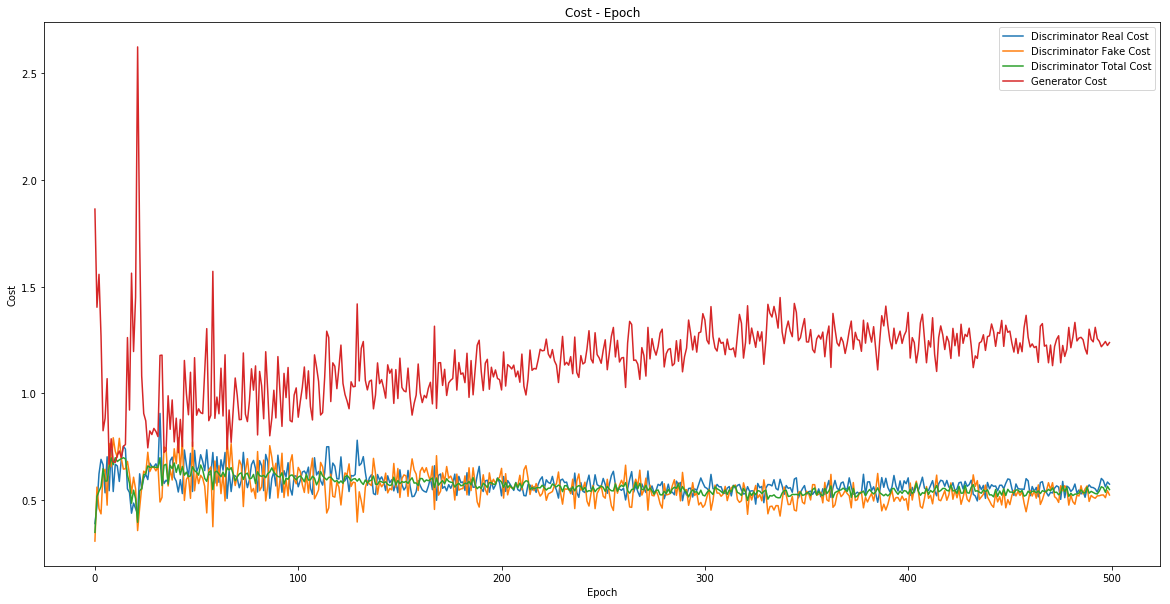

In [8]:
costs = np.array(costs_history).T
plt.figure(figsize=(20, 10))
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.title('Cost - Epoch')
plt.plot(costs[0], label='Discriminator Real Cost')
plt.plot(costs[1], label='Discriminator Fake Cost')
plt.plot(costs[2], label='Discriminator Total Cost')
plt.plot(costs[3], label='Generator Cost')
plt.legend(loc='best')
plt.show()

Epoch 1:


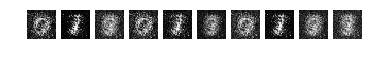

Epoch 2:


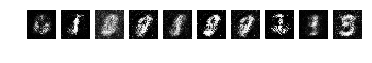

Epoch 3:


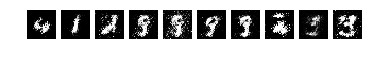

Epoch 4:


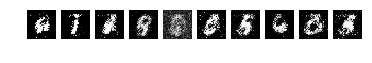

Epoch 5:


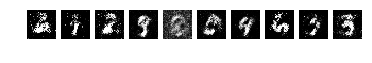

Epoch 6:


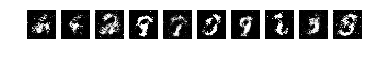

Epoch 7:


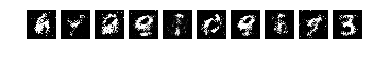

Epoch 8:


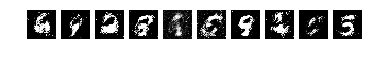

Epoch 9:


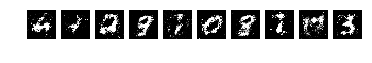

Epoch 10:


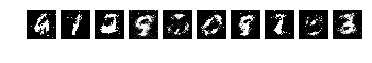

Epoch 11:


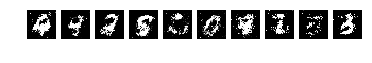

Epoch 12:


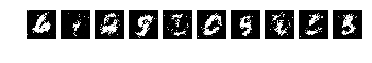

Epoch 13:


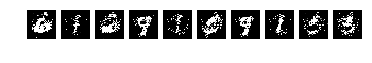

Epoch 14:


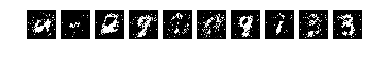

Epoch 15:


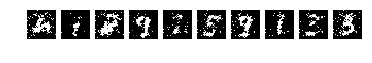

Epoch 16:


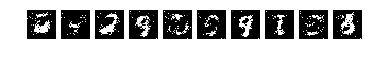

Epoch 17:


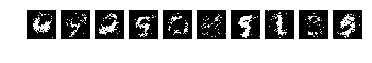

Epoch 18:


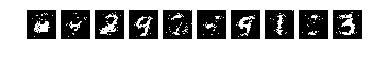

Epoch 19:


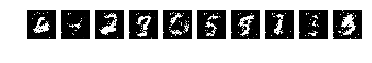

Epoch 20:


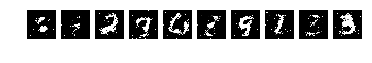

Epoch 21:


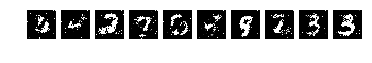

Epoch 22:


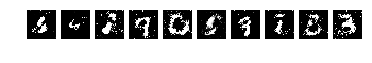

Epoch 23:


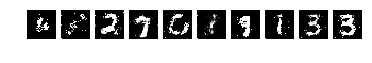

Epoch 24:


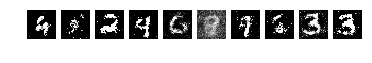

Epoch 25:


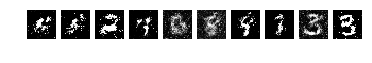

Epoch 26:


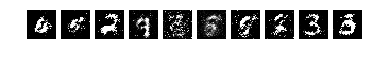

Epoch 27:


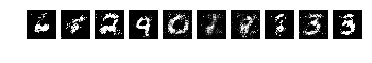

Epoch 28:


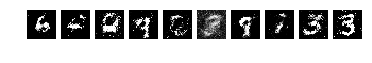

Epoch 29:


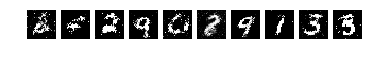

Epoch 30:


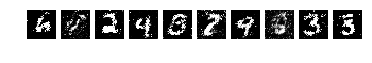

Epoch 31:


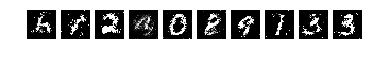

Epoch 32:


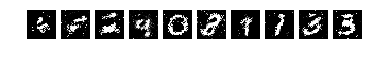

Epoch 33:


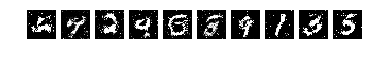

Epoch 34:


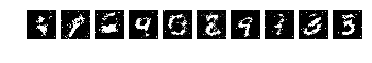

Epoch 35:


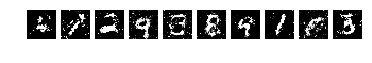

Epoch 36:


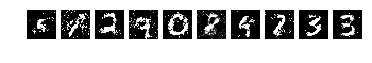

Epoch 37:


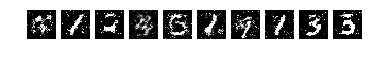

Epoch 38:


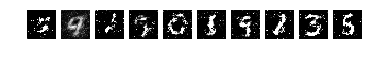

Epoch 39:


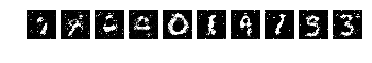

Epoch 40:


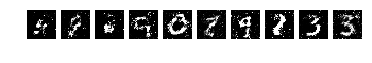

Epoch 41:


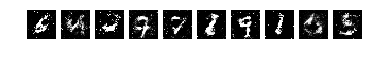

Epoch 42:


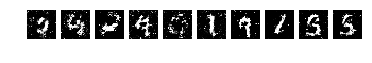

Epoch 43:


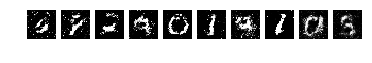

Epoch 44:


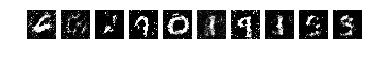

Epoch 45:


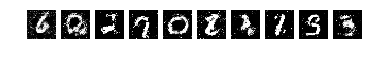

Epoch 46:


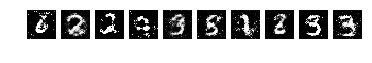

Epoch 47:


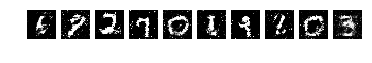

Epoch 48:


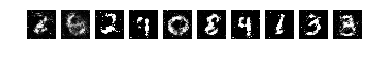

Epoch 49:


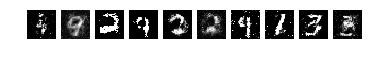

Epoch 50:


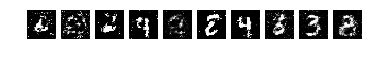

Epoch 51:


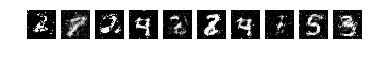

Epoch 52:


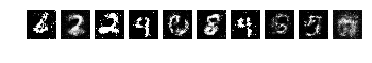

Epoch 53:


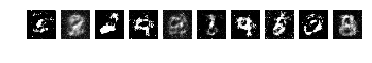

Epoch 54:


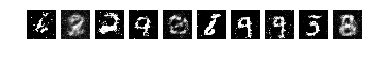

Epoch 55:


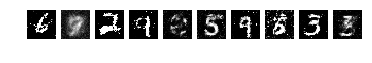

Epoch 56:


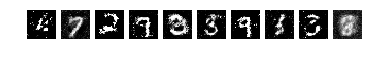

Epoch 57:


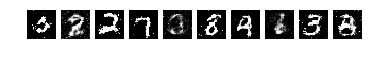

Epoch 58:


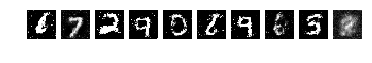

Epoch 59:


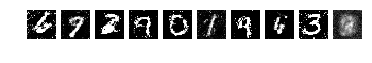

Epoch 60:


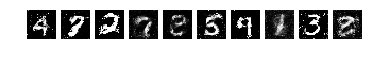

Epoch 61:


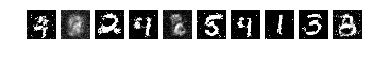

Epoch 62:


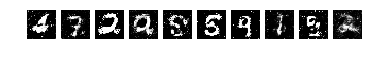

Epoch 63:


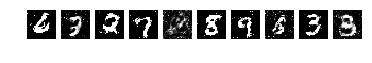

Epoch 64:


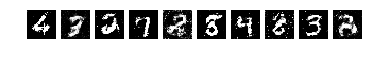

Epoch 65:


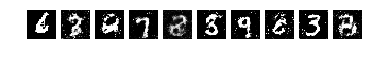

Epoch 66:


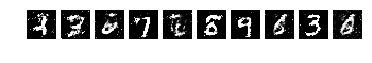

Epoch 67:


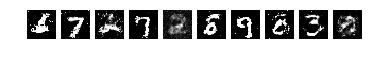

Epoch 68:


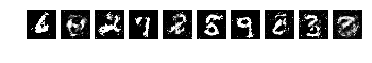

Epoch 69:


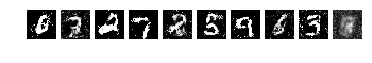

Epoch 70:


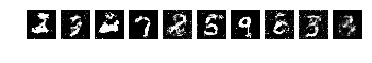

Epoch 71:


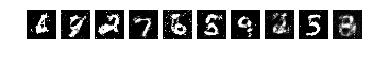

Epoch 72:


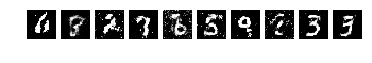

Epoch 73:


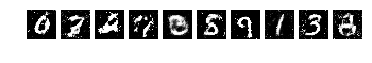

Epoch 74:


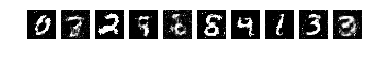

Epoch 75:


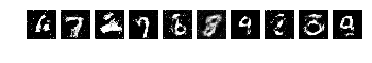

Epoch 76:


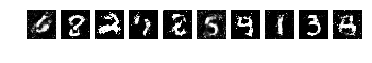

Epoch 77:


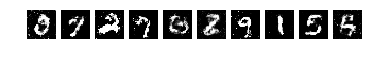

Epoch 78:


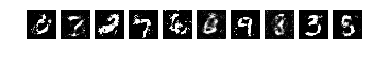

Epoch 79:


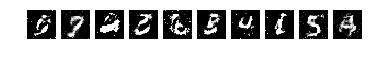

Epoch 80:


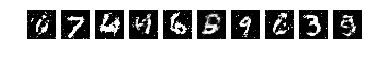

Epoch 81:


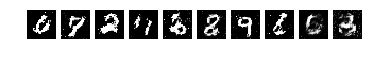

Epoch 82:


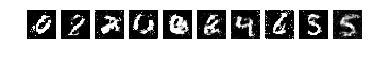

Epoch 83:


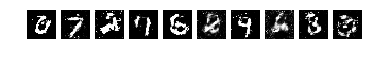

Epoch 84:


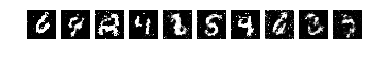

Epoch 85:


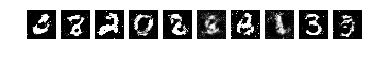

Epoch 86:


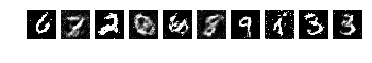

Epoch 87:


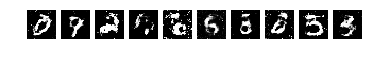

Epoch 88:


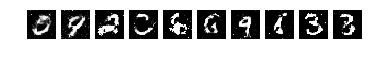

Epoch 89:


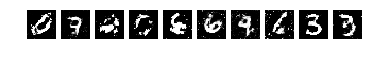

Epoch 90:


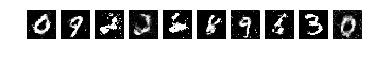

Epoch 91:


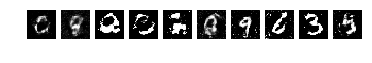

Epoch 92:


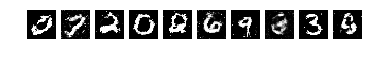

Epoch 93:


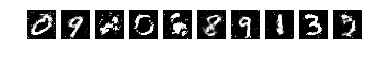

Epoch 94:


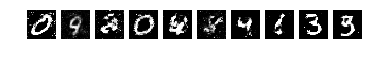

Epoch 95:


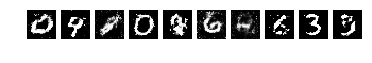

Epoch 96:


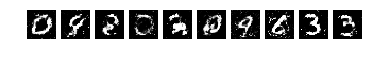

Epoch 97:


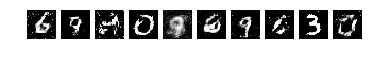

Epoch 98:


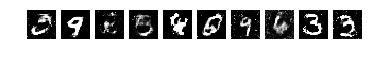

Epoch 99:


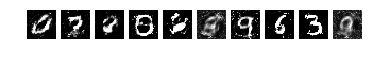

Epoch 100:


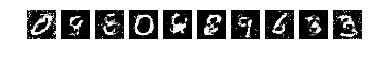

Epoch 101:


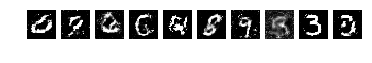

Epoch 102:


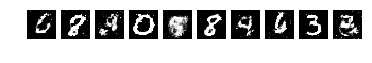

Epoch 103:


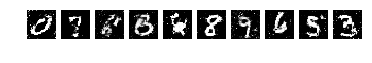

Epoch 104:


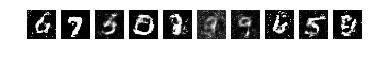

Epoch 105:


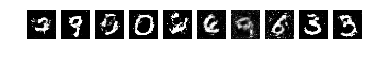

Epoch 106:


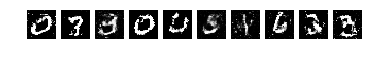

Epoch 107:


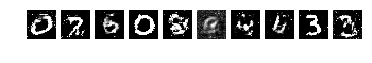

Epoch 108:


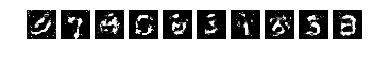

Epoch 109:


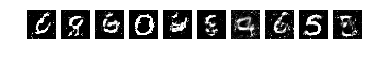

Epoch 110:


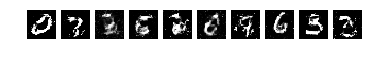

Epoch 111:


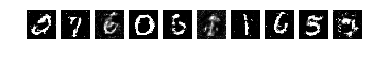

Epoch 112:


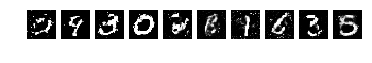

Epoch 113:


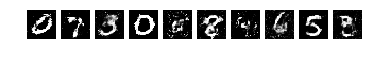

Epoch 114:


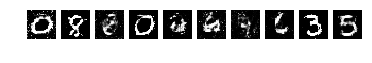

Epoch 115:


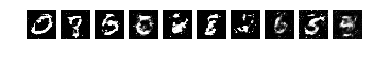

Epoch 116:


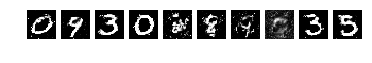

Epoch 117:


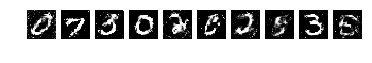

Epoch 118:


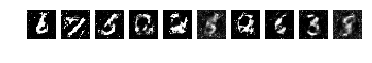

Epoch 119:


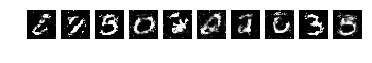

Epoch 120:


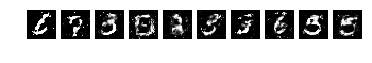

Epoch 121:


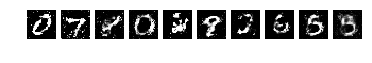

Epoch 122:


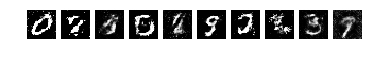

Epoch 123:


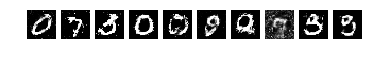

Epoch 124:


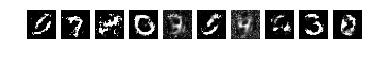

Epoch 125:


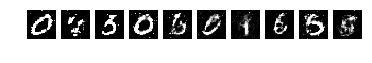

Epoch 126:


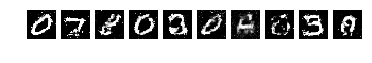

Epoch 127:


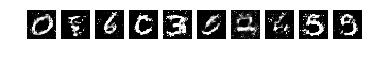

Epoch 128:


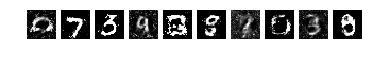

Epoch 129:


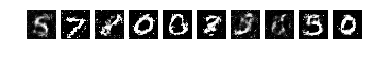

Epoch 130:


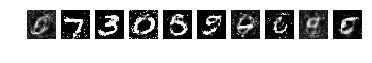

Epoch 131:


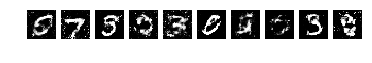

Epoch 132:


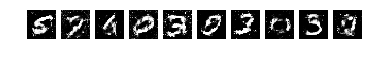

Epoch 133:


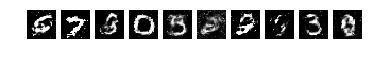

Epoch 134:


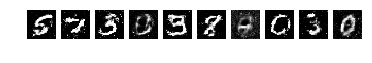

Epoch 135:


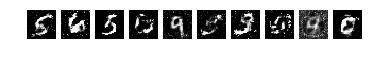

Epoch 136:


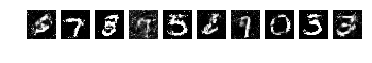

Epoch 137:


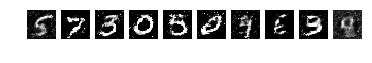

Epoch 138:


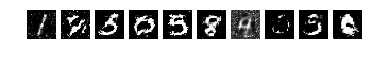

Epoch 139:


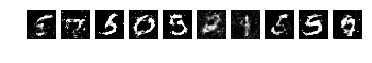

Epoch 140:


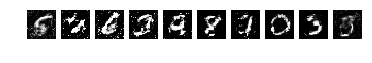

Epoch 141:


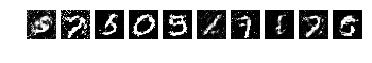

Epoch 142:


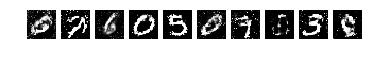

Epoch 143:


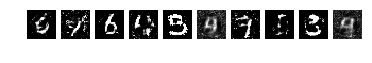

Epoch 144:


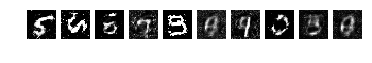

Epoch 145:


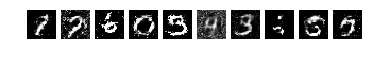

Epoch 146:


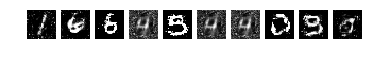

Epoch 147:


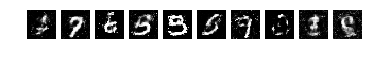

Epoch 148:


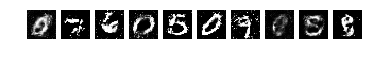

Epoch 149:


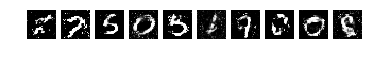

Epoch 150:


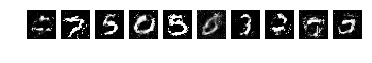

Epoch 151:


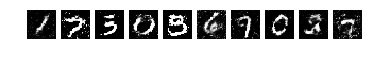

Epoch 152:


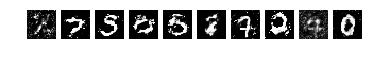

Epoch 153:


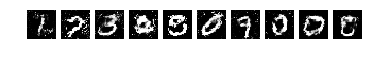

Epoch 154:


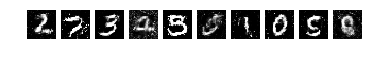

Epoch 155:


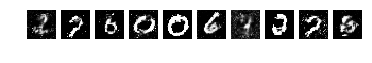

Epoch 156:


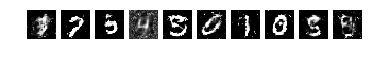

Epoch 157:


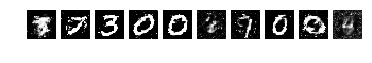

Epoch 158:


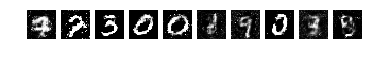

Epoch 159:


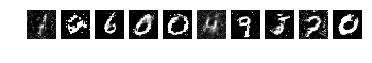

Epoch 160:


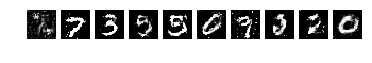

Epoch 161:


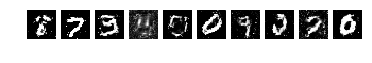

Epoch 162:


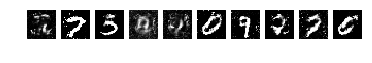

Epoch 163:


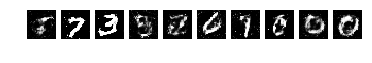

Epoch 164:


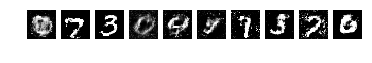

Epoch 165:


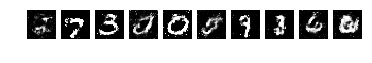

Epoch 166:


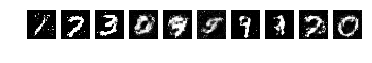

Epoch 167:


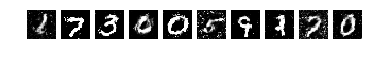

Epoch 168:


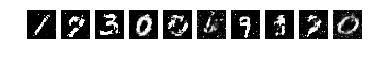

Epoch 169:


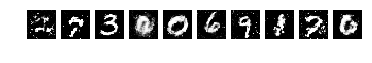

Epoch 170:


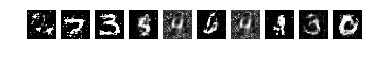

Epoch 171:


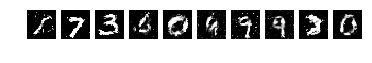

Epoch 172:


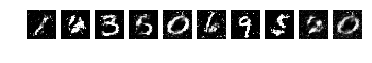

Epoch 173:


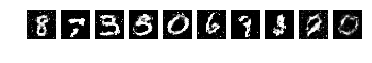

Epoch 174:


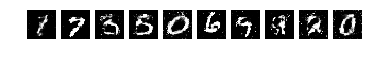

Epoch 175:


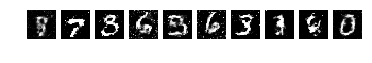

Epoch 176:


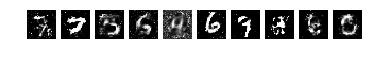

Epoch 177:


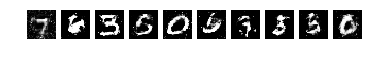

Epoch 178:


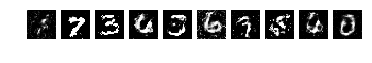

Epoch 179:


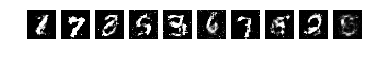

Epoch 180:


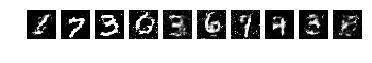

Epoch 181:


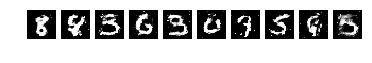

Epoch 182:


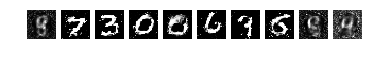

Epoch 183:


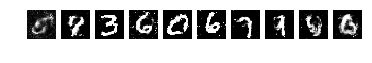

Epoch 184:


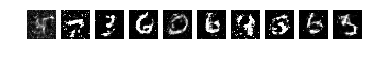

Epoch 185:


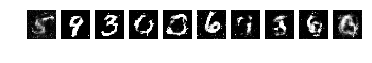

Epoch 186:


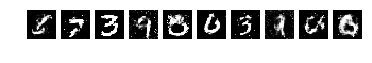

Epoch 187:


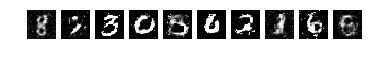

Epoch 188:


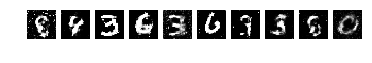

Epoch 189:


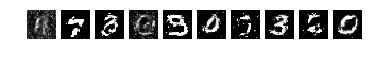

Epoch 190:


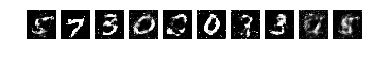

Epoch 191:


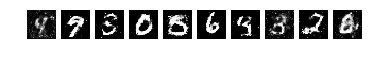

Epoch 192:


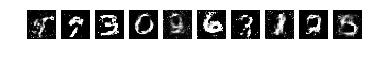

Epoch 193:


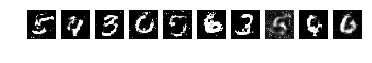

Epoch 194:


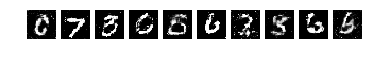

Epoch 195:


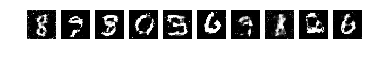

Epoch 196:


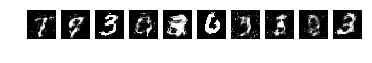

Epoch 197:


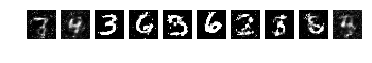

Epoch 198:


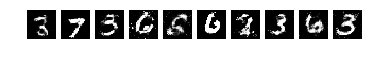

Epoch 199:


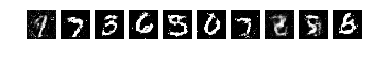

Epoch 200:


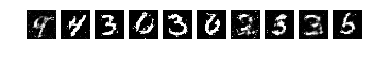

Epoch 201:


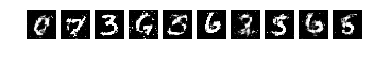

Epoch 202:


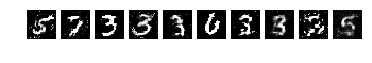

Epoch 203:


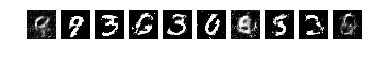

Epoch 204:


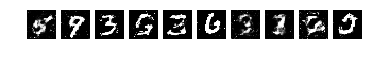

Epoch 205:


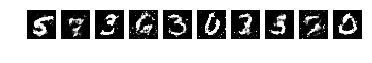

Epoch 206:


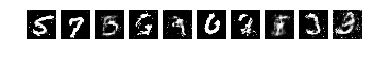

Epoch 207:


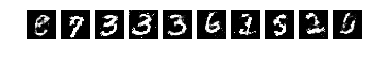

Epoch 208:


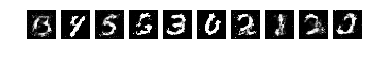

Epoch 209:


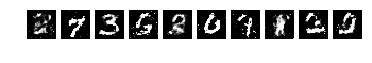

Epoch 210:


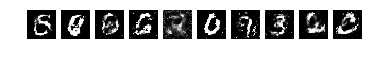

Epoch 211:


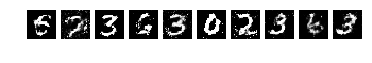

Epoch 212:


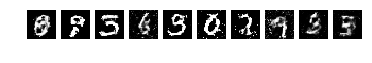

Epoch 213:


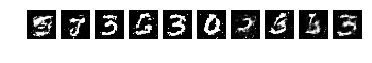

Epoch 214:


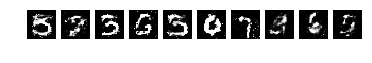

Epoch 215:


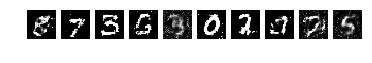

Epoch 216:


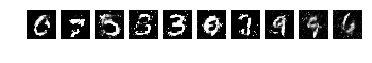

Epoch 217:


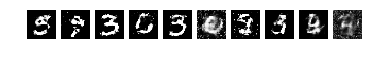

Epoch 218:


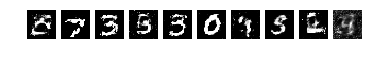

Epoch 219:


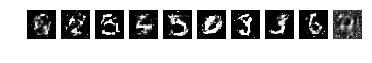

Epoch 220:


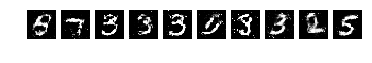

Epoch 221:


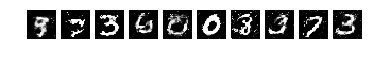

Epoch 222:


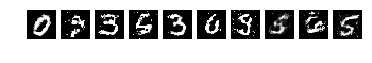

Epoch 223:


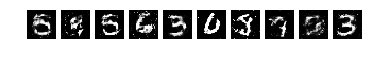

Epoch 224:


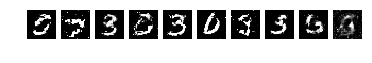

Epoch 225:


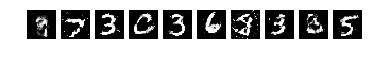

Epoch 226:


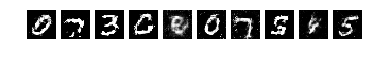

Epoch 227:


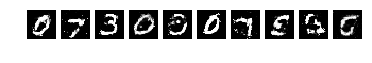

Epoch 228:


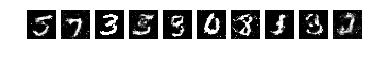

Epoch 229:


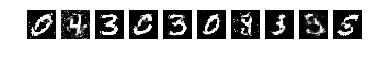

Epoch 230:


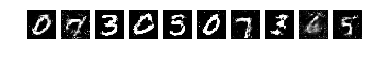

Epoch 231:


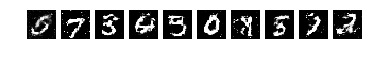

Epoch 232:


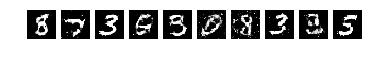

Epoch 233:


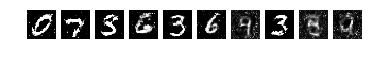

Epoch 234:


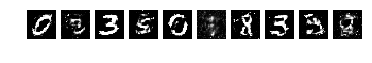

Epoch 235:


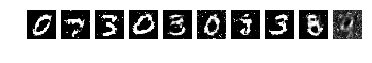

Epoch 236:


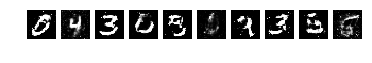

Epoch 237:


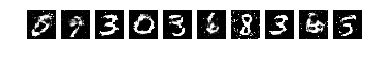

Epoch 238:


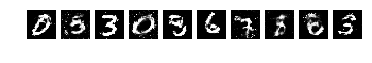

Epoch 239:


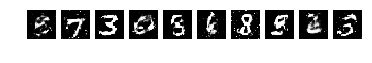

Epoch 240:


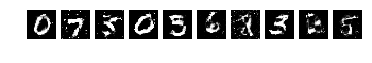

Epoch 241:


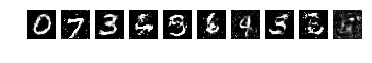

Epoch 242:


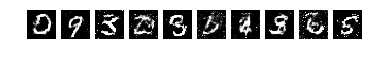

Epoch 243:


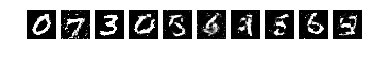

Epoch 244:


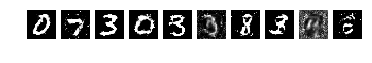

Epoch 245:


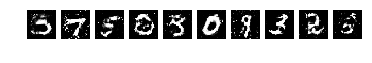

Epoch 246:


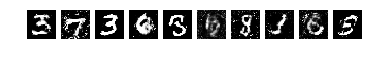

Epoch 247:


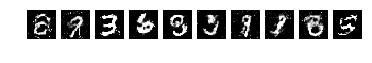

Epoch 248:


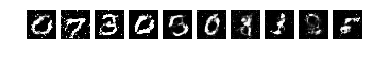

Epoch 249:


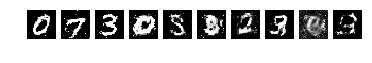

Epoch 250:


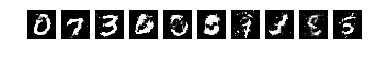

Epoch 251:


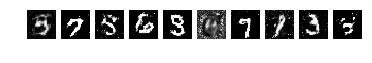

Epoch 252:


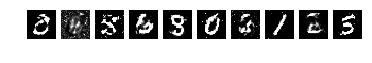

Epoch 253:


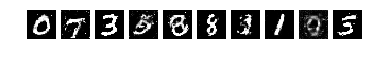

Epoch 254:


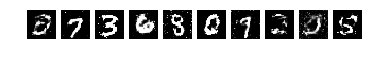

Epoch 255:


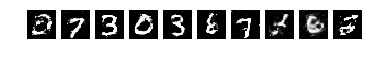

Epoch 256:


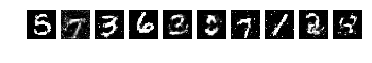

Epoch 257:


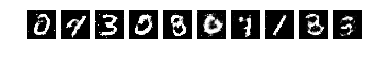

Epoch 258:


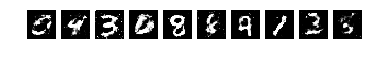

Epoch 259:


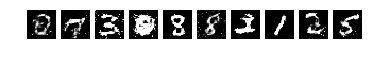

Epoch 260:


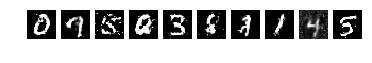

Epoch 261:


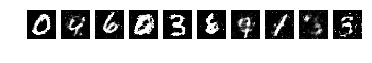

Epoch 262:


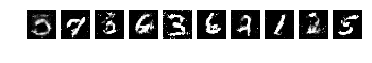

Epoch 263:


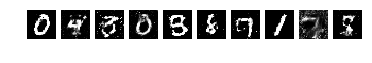

Epoch 264:


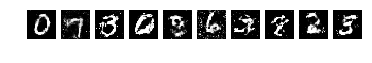

Epoch 265:


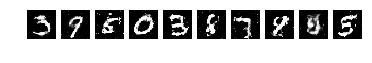

Epoch 266:


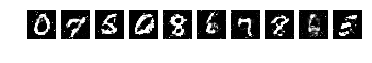

Epoch 267:


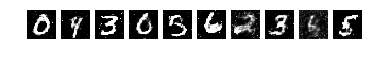

Epoch 268:


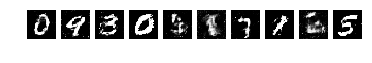

Epoch 269:


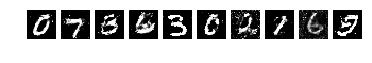

Epoch 270:


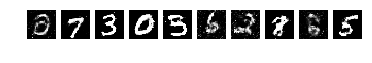

Epoch 271:


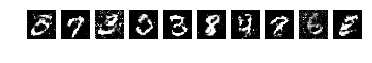

Epoch 272:


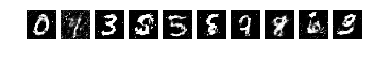

Epoch 273:


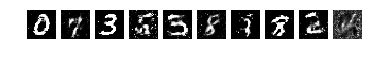

Epoch 274:


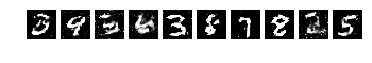

Epoch 275:


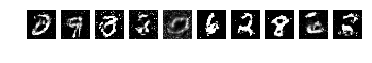

Epoch 276:


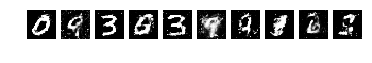

Epoch 277:


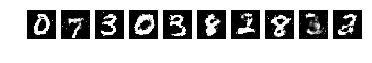

Epoch 278:


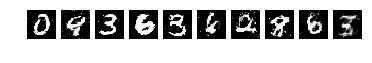

Epoch 279:


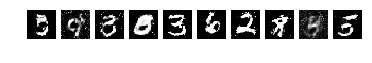

Epoch 280:


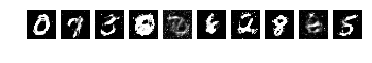

Epoch 281:


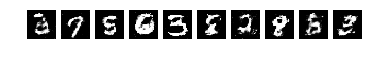

Epoch 282:


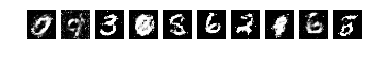

Epoch 283:


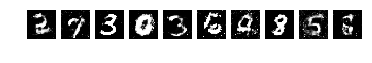

Epoch 284:


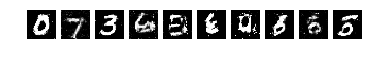

Epoch 285:


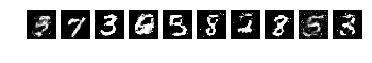

Epoch 286:


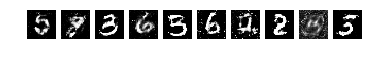

Epoch 287:


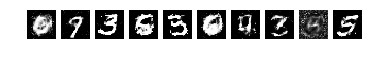

Epoch 288:


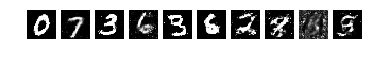

Epoch 289:


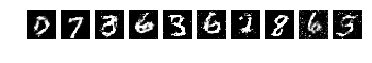

Epoch 290:


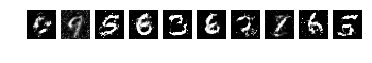

Epoch 291:


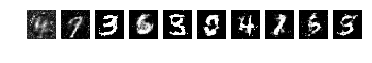

Epoch 292:


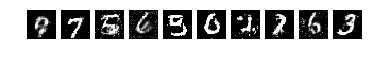

Epoch 293:


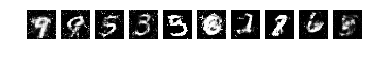

Epoch 294:


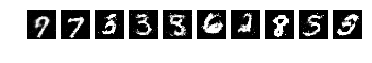

Epoch 295:


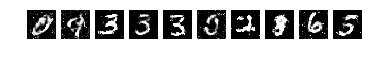

Epoch 296:


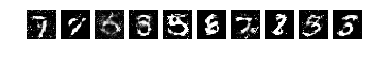

Epoch 297:


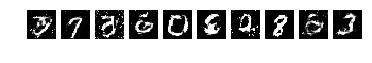

Epoch 298:


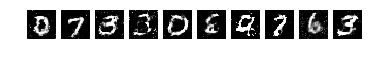

Epoch 299:


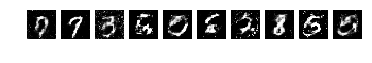

Epoch 300:


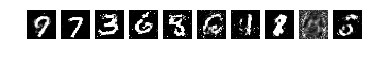

Epoch 301:


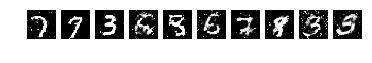

Epoch 302:


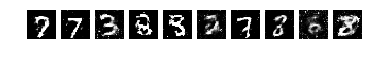

Epoch 303:


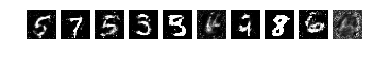

Epoch 304:


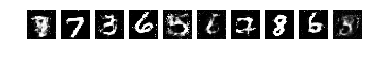

Epoch 305:


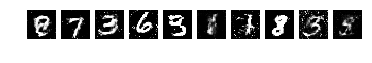

Epoch 306:


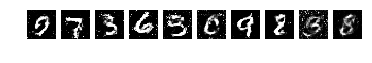

Epoch 307:


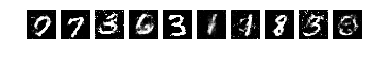

Epoch 308:


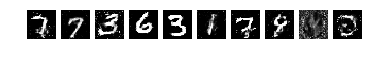

Epoch 309:


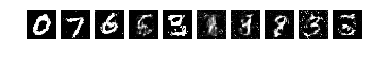

Epoch 310:


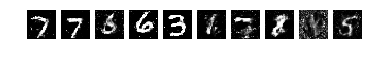

Epoch 311:


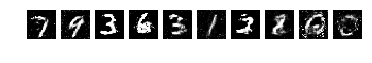

Epoch 312:


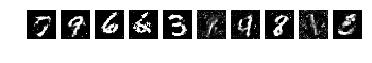

Epoch 313:


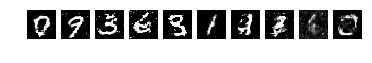

Epoch 314:


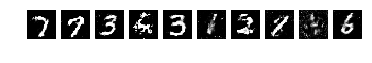

Epoch 315:


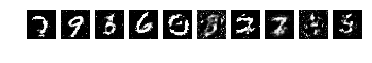

Epoch 316:


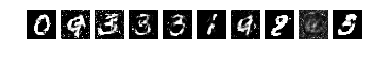

Epoch 317:


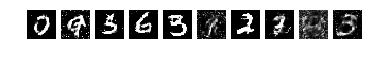

Epoch 318:


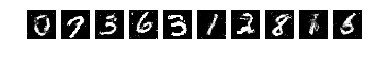

Epoch 319:


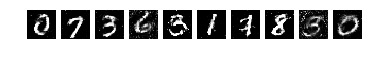

Epoch 320:


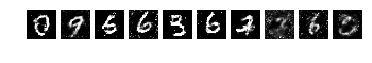

Epoch 321:


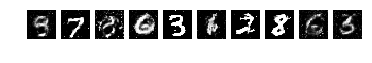

Epoch 322:


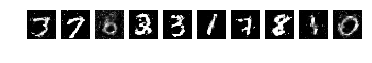

Epoch 323:


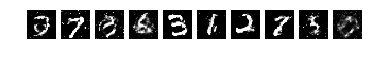

Epoch 324:


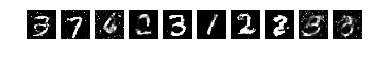

Epoch 325:


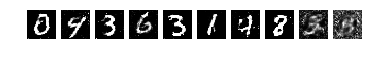

Epoch 326:


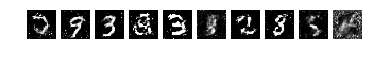

Epoch 327:


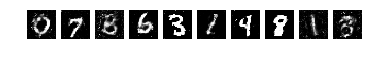

Epoch 328:


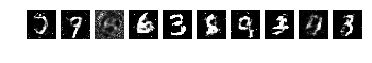

Epoch 329:


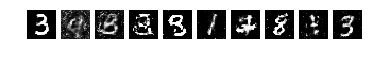

Epoch 330:


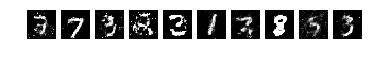

Epoch 331:


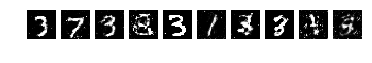

Epoch 332:


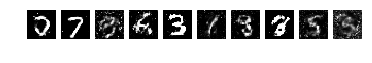

Epoch 333:


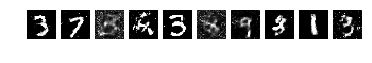

Epoch 334:


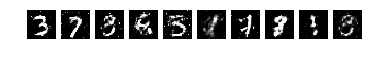

Epoch 335:


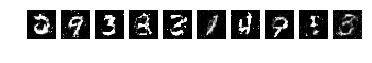

Epoch 336:


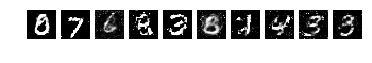

Epoch 337:


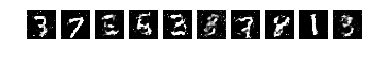

Epoch 338:


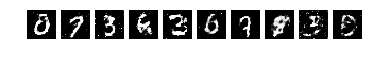

Epoch 339:


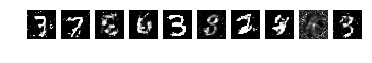

Epoch 340:


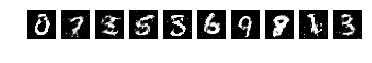

Epoch 341:


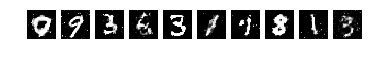

Epoch 342:


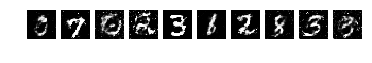

Epoch 343:


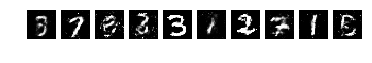

Epoch 344:


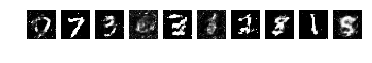

Epoch 345:


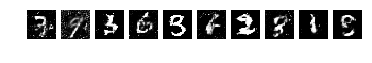

Epoch 346:


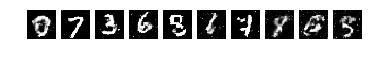

Epoch 347:


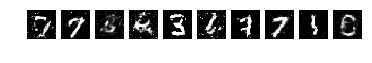

Epoch 348:


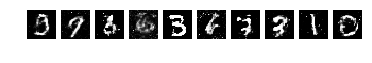

Epoch 349:


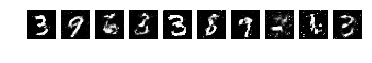

Epoch 350:


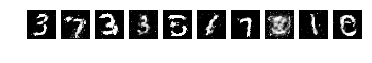

Epoch 351:


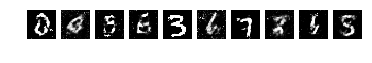

Epoch 352:


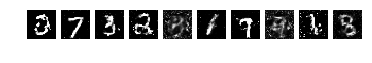

Epoch 353:


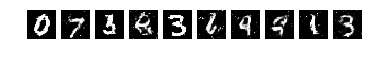

Epoch 354:


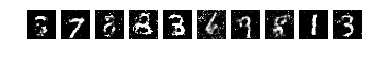

Epoch 355:


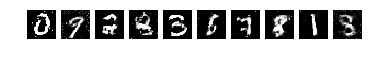

Epoch 356:


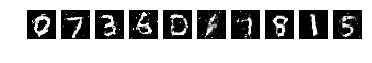

Epoch 357:


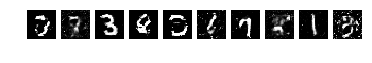

Epoch 358:


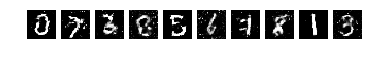

Epoch 359:


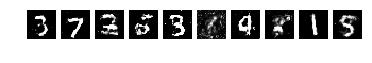

Epoch 360:


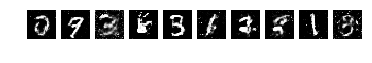

Epoch 361:


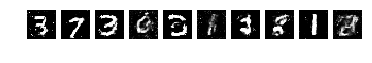

Epoch 362:


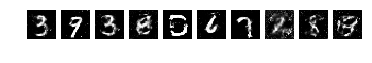

Epoch 363:


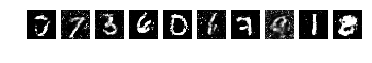

Epoch 364:


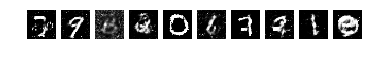

Epoch 365:


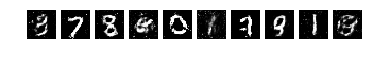

Epoch 366:


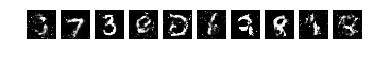

Epoch 367:


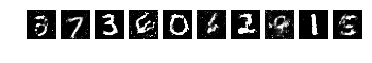

Epoch 368:


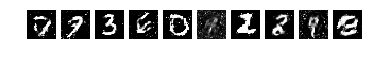

Epoch 369:


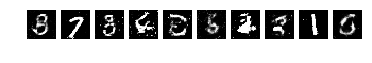

Epoch 370:


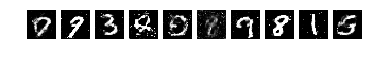

Epoch 371:


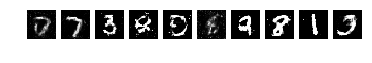

Epoch 372:


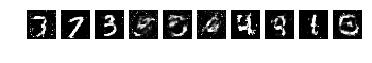

Epoch 373:


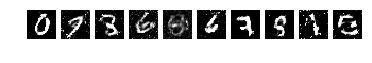

Epoch 374:


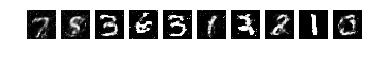

Epoch 375:


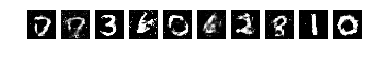

Epoch 376:


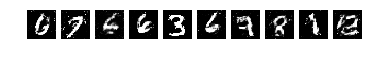

Epoch 377:


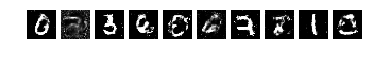

Epoch 378:


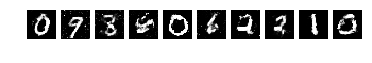

Epoch 379:


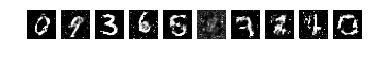

Epoch 380:


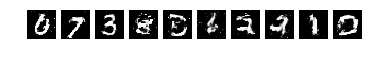

Epoch 381:


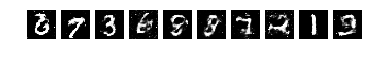

Epoch 382:


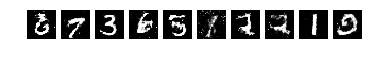

Epoch 383:


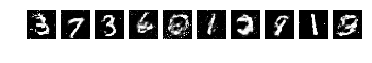

Epoch 384:


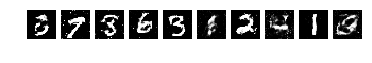

Epoch 385:


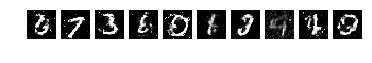

Epoch 386:


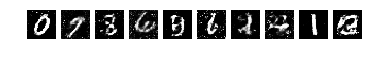

Epoch 387:


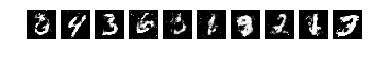

Epoch 388:


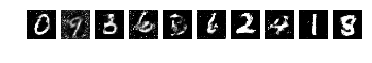

Epoch 389:


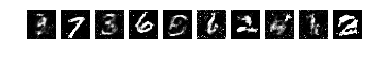

Epoch 390:


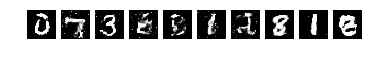

Epoch 391:


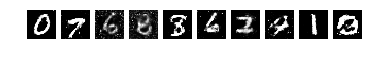

Epoch 392:


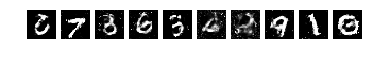

Epoch 393:


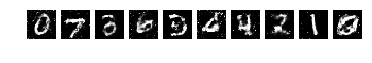

Epoch 394:


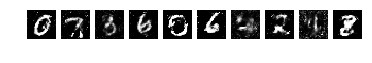

Epoch 395:


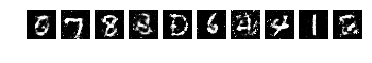

Epoch 396:


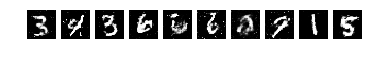

Epoch 397:


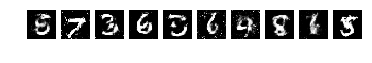

Epoch 398:


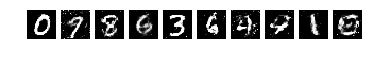

Epoch 399:


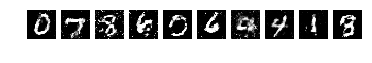

Epoch 400:


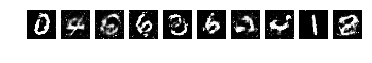

Epoch 401:


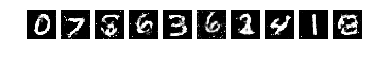

Epoch 402:


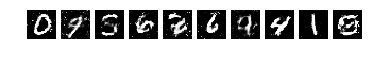

Epoch 403:


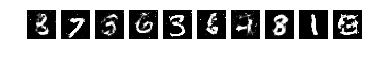

Epoch 404:


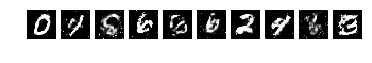

Epoch 405:


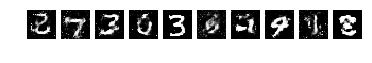

Epoch 406:


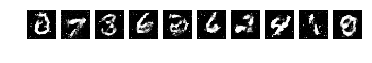

Epoch 407:


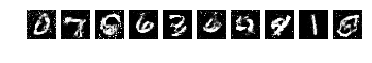

Epoch 408:


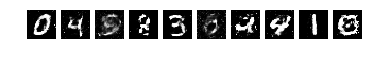

Epoch 409:


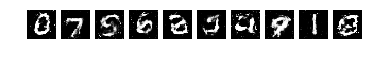

Epoch 410:


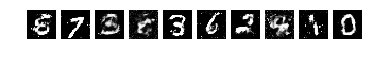

Epoch 411:


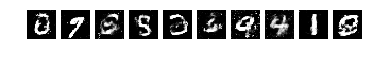

Epoch 412:


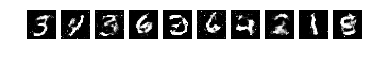

Epoch 413:


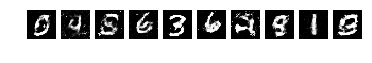

Epoch 414:


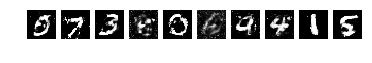

Epoch 415:


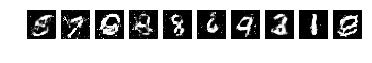

Epoch 416:


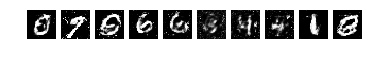

Epoch 417:


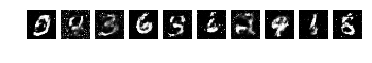

Epoch 418:


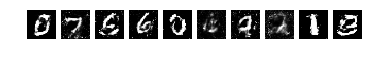

Epoch 419:


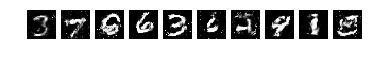

Epoch 420:


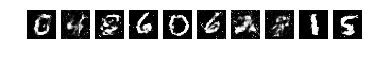

Epoch 421:


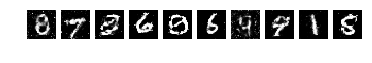

Epoch 422:


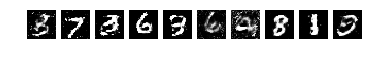

Epoch 423:


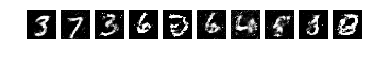

Epoch 424:


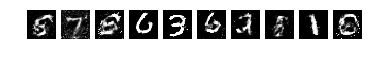

Epoch 425:


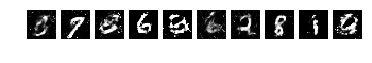

Epoch 426:


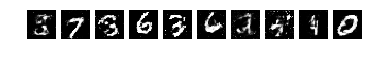

Epoch 427:


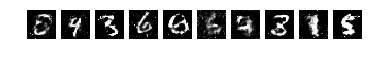

Epoch 428:


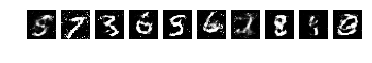

Epoch 429:


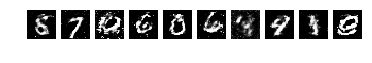

Epoch 430:


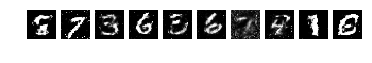

Epoch 431:


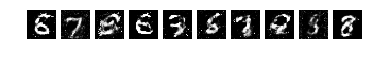

Epoch 432:


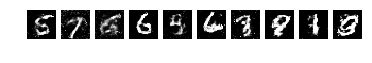

Epoch 433:


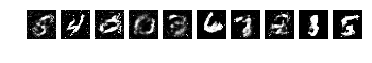

Epoch 434:


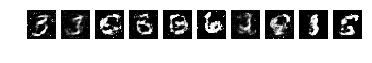

Epoch 435:


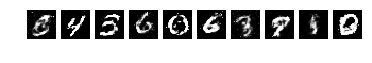

Epoch 436:


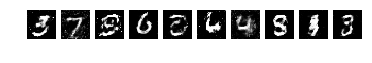

Epoch 437:


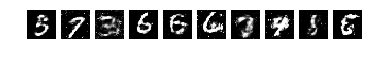

Epoch 438:


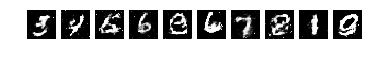

Epoch 439:


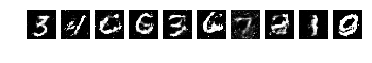

Epoch 440:


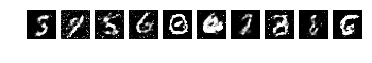

Epoch 441:


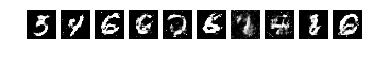

Epoch 442:


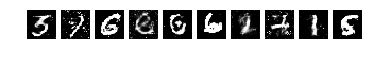

Epoch 443:


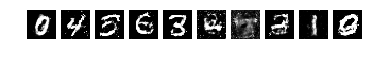

Epoch 444:


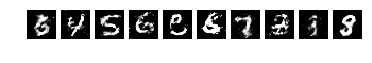

Epoch 445:


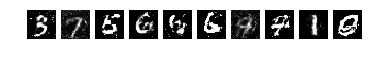

Epoch 446:


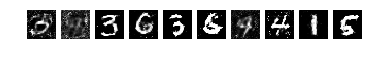

Epoch 447:


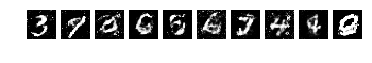

Epoch 448:


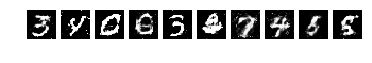

Epoch 449:


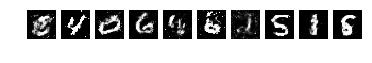

Epoch 450:


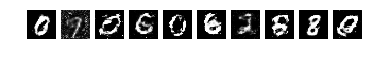

Epoch 451:


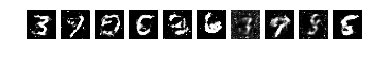

Epoch 452:


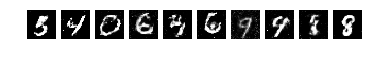

Epoch 453:


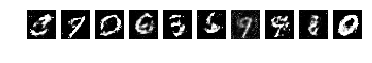

Epoch 454:


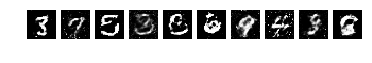

Epoch 455:


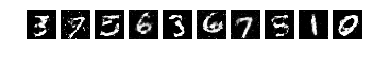

Epoch 456:


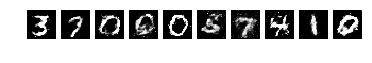

Epoch 457:


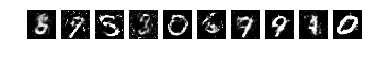

Epoch 458:


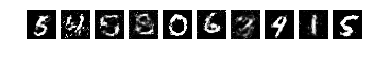

Epoch 459:


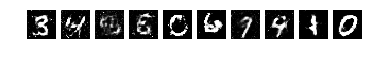

Epoch 460:


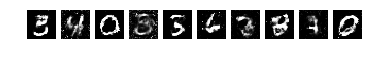

Epoch 461:


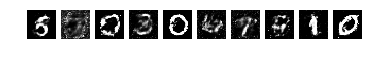

Epoch 462:


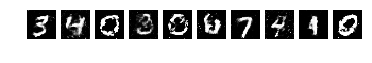

Epoch 463:


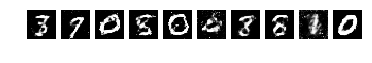

Epoch 464:


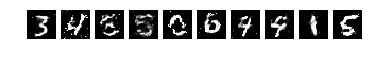

Epoch 465:


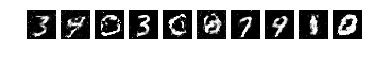

Epoch 466:


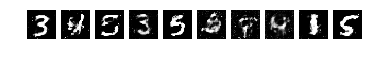

Epoch 467:


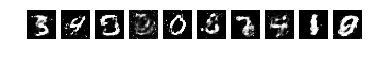

Epoch 468:


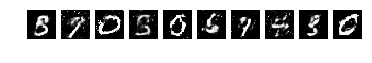

Epoch 469:


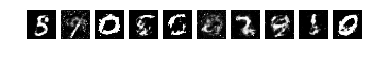

Epoch 470:


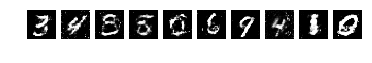

Epoch 471:


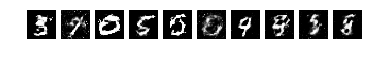

Epoch 472:


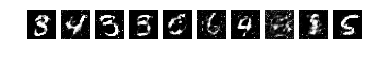

Epoch 473:


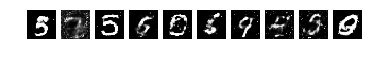

Epoch 474:


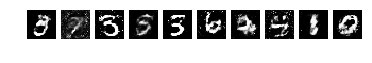

Epoch 475:


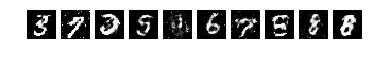

Epoch 476:


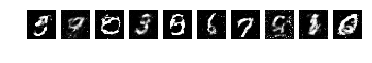

Epoch 477:


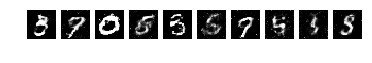

Epoch 478:


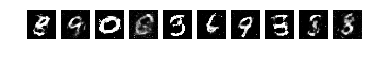

Epoch 479:


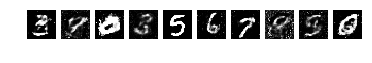

Epoch 480:


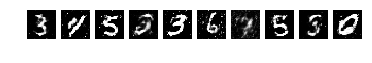

Epoch 481:


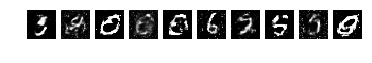

Epoch 482:


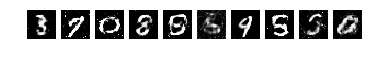

Epoch 483:


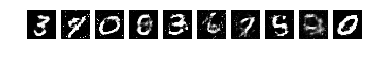

Epoch 484:


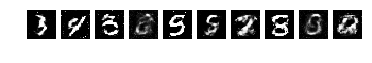

Epoch 485:


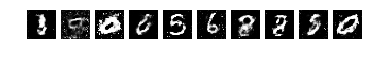

Epoch 486:


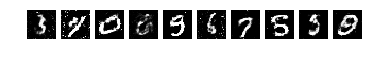

Epoch 487:


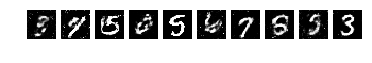

Epoch 488:


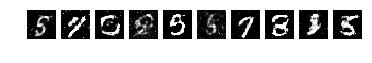

Epoch 489:


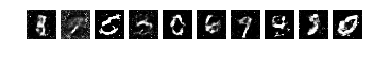

Epoch 490:


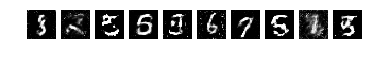

Epoch 491:


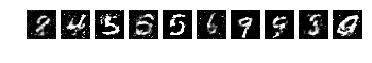

Epoch 492:


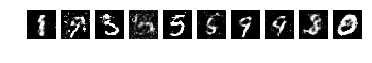

Epoch 493:


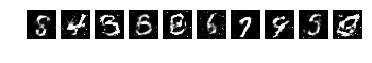

Epoch 494:


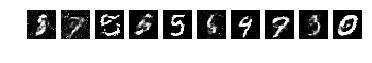

Epoch 495:


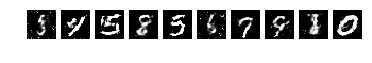

Epoch 496:


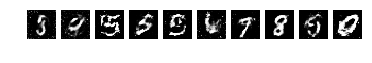

Epoch 497:


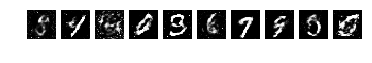

Epoch 498:


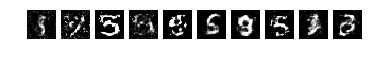

Epoch 499:


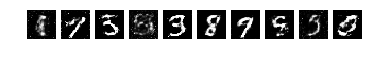

Epoch 500:


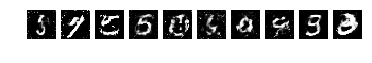

In [9]:
for i in range(hyperparams['epoch']):
    print('Epoch {}:'.format(i + 1))
    for j in range(hyperparams['sample_size']):
        plt.subplot(1, hyperparams['sample_size'], j + 1)
        plt.axis('off')
        plt.imshow(generate_sample_history[i, j].reshape(28, 28), cmap='gray')   
    plt.show()